In [5]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [6]:
cd LC_data/

[Errno 2] No such file or directory: 'LC_data/'
/Users/abhishek/Desktop/gan_sdn/Gan_MTX/LC_data


In [7]:
data=pd.read_csv("Final_data_set_18_features.csv")
del data["Unnamed: 0"]
d_0=data.loc[data['Response'] == 0]
d_0_sample=d_0.sample(5000)
d_1=data.loc[data['Response'] == 1]
d_1_sample=d_1.sample(5000)

data=pd.concat([d_0_sample,d_1_sample])

from sklearn.utils import shuffle
data = shuffle(data)

def dictionary(val):
    number_of_categories=len(val.unique())
    if number_of_categories==2:
        ar=[0,1]
    else:
        ar=np.linspace(0,1,number_of_categories)
    categories=val.unique()
    dic= dict(zip(categories, ar))
    
    return(dic)

data['application_type'].replace(dictionary(data['application_type']), inplace=True)
data['sub_grade'].replace(dictionary(data['sub_grade']), inplace=True)
data['term'].replace(dictionary(data['term']), inplace=True)
data['emp_length'].replace(dictionary(data['emp_length']), inplace=True)
data['home_ownership'].replace(dictionary(data['home_ownership']), inplace=True)

data_cols = list(data.columns[ data.columns != 'Response' ])
label_cols = ['Response']
print(data_cols)
print('# of data columns: ',len(data_cols))


train = data.copy()
label_cols = ['Response']
data_cols = list(data.columns[ data.columns != 'Response' ])

#print(data_cols)
print('# of data columns: ',len(data_cols))

## removing the nan columns as they are continous variables with classes equal to 0 and 1
data_cols = list(set(data_cols) - set(['application_type','term','delinq_2yrs','home_ownership']))
                                       
print(data_cols)
print('# of data columns: ',len(data_cols))

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

print(percentiles)
percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

data_backup = data.copy()

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

test_cols = data.columns

['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
# of data columns:  18
# of data columns:  18
['emp_length', 'annual_inc_joint', 'interest_ration_to_princi_amt', 'out_prncp', 'funded_amnt', 'open_to_total_Acc', 'acc_open_past_24mths', 'int_rate', 'dti_joint', 'total_pymnt', 'all_util', 'total_revol_util', 'sub_grade', 'last_credit_pull_d_month']
# of data columns:  14
     emp_length  annual_inc_joint  interest_ration_to_princi_amt    out_prncp  \
min         0.0           12000.0                       1.978800      0.00000   
max         1.0          300000.0                       4.055253  27149.90267   

     funded_amnt  open_to_total_Acc  acc_open_past_24mths  int_rate  \
min       1000.0           0.124992            

In [8]:
import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

rand_dim = 18 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = train.copy().reset_index(drop=True) # fraud only with labels from classification
print(type(train))
print(train.head(2))
print(train.shape)

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Response' in i ]
print(label_cols)
data_cols = [ i for i in train.columns if i not in label_cols ]
print(data_cols)
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]
print(train_no_label.shape)

/Users/abhishek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/abhishek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abhishek/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abhishek/anaconda3/lib/python3.

<class 'pandas.core.frame.DataFrame'>
    all_util  application_type  funded_amnt  last_credit_pull_d_month  \
0  38.000000                 0        13000                  4.074006   
1  41.603081                 0        19200                 25.133986   

   acc_open_past_24mths  open_to_total_Acc  annual_inc_joint  out_prncp  \
0                   5.0           0.611111           52000.0        0.0   
1                   2.0           0.384615           73000.0        0.0   

   sub_grade  term  delinq_2yrs  emp_length  home_ownership  int_rate  \
0   0.000000     0          0.0         0.0        0.000000     15.31   
1   0.029412     0          1.0         0.0        0.333333     16.99   

   total_revol_util  interest_ration_to_princi_amt  dti_joint  total_pymnt  \
0              23.2                       2.395308      16.36      8846.81   
1              47.2                       2.484740      22.09     23396.69   

   Response  
0         0  
1         1  
(10000, 19)
['Respo

data_dim:  18
data_cols:  ['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________

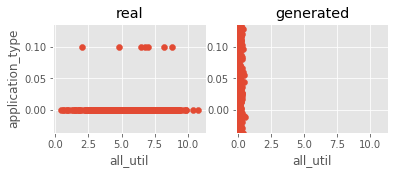

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -52.8993, 51.0466, 22661.6738, 1.0000
D Real - D Gen: 22610.6270


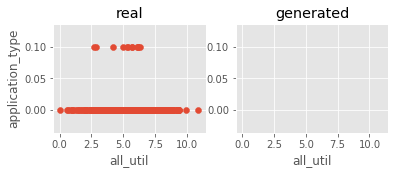

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: -236.6776, 245.7588, 23019.2910, 1.0000
D Real - D Gen: 22773.5332


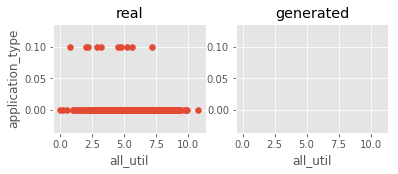

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -647.7303, 632.7263, 23299.8105, 1.0000
D Real - D Gen: 22667.0840


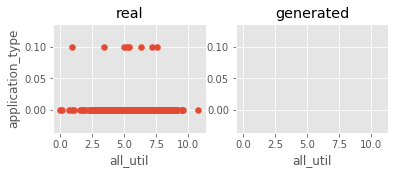

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -1357.8082, 1343.9321, 20647.1699, 1.0000
D Real - D Gen: 19303.2383


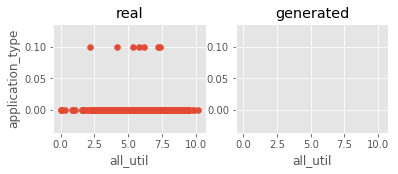

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -2235.5894, 2357.9468, 20129.8086, 1.0000
D Real - D Gen: 17771.8613


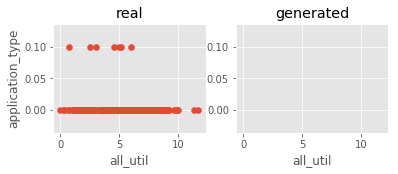

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: -3328.4294, 3284.2783, 18424.3945, 1.0000
D Real - D Gen: 15140.1162


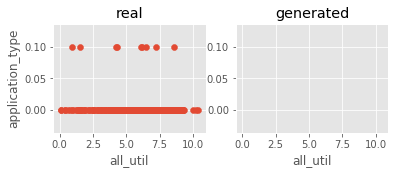

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -3972.5935, 4194.0054, 15613.0996, 1.0000
D Real - D Gen: 11419.0938


Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -4263.3516, 4458.3359, 11904.8877, 0.9966
D Real - D Gen: 7446.5518


Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -3918.6956, 4034.8784, 7942.0757, 1.0000
D Real - D Gen: 3907.1973


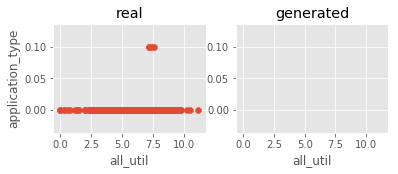

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: -2913.7786, 2921.8093, 4987.9517, 1.0000
D Real - D Gen: 2066.1423


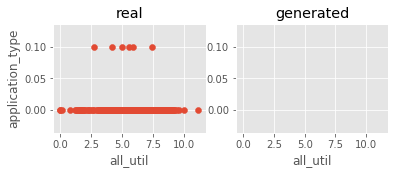

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -109.3166, -74.4379, 749.9225, 1.0000
D Real - D Gen: 824.3604


Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -434.6120, 494.5844, 1089.7212, 1.0000
D Real - D Gen: 595.1368


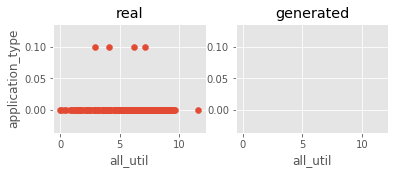

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 129.0943, -27.5276, 542.2686, 1.0000
D Real - D Gen: 569.7961


Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -367.8272, 228.6684, 755.3336, 1.0000
D Real - D Gen: 526.6652


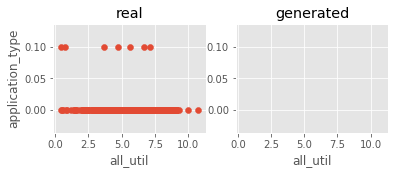

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 72.0522, -137.0507, 348.2119, 1.0000
D Real - D Gen: 485.2626


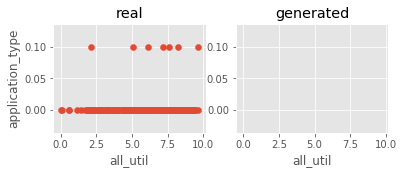

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 11.4315, 64.9593, 568.4056, 1.0000
D Real - D Gen: 503.4463


Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 91.7033, -285.6264, 208.2420, 1.0000
D Real - D Gen: 493.8683


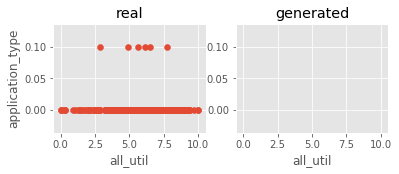

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 508.7695, -822.2377, -327.7237, 1.0000
D Real - D Gen: 494.5140


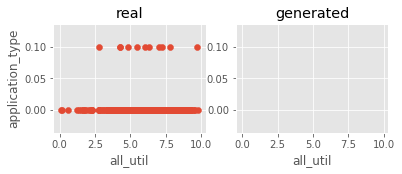

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -310.5889, 153.6946, 645.5961, 1.0000
D Real - D Gen: 491.9014


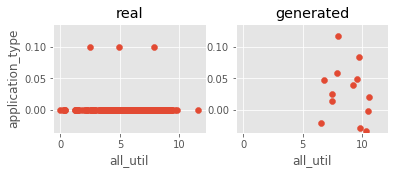

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -902.0449, 649.0226, 1311.5973, 0.9966
D Real - D Gen: 662.5747


Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 496.1775, -390.5247, 139.5793, 1.0000
D Real - D Gen: 530.1039


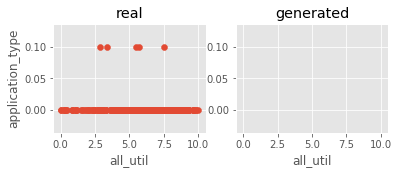

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 247.8682, -37.6208, 415.4001, 1.0000
D Real - D Gen: 453.0209


Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 343.4511, -353.5042, 144.4242, 1.0000
D Real - D Gen: 497.9284


Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: -405.7509, 592.4543, 1036.8921, 1.0000
D Real - D Gen: 444.4378


Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: -1491.7930, 1465.5266, 1957.5928, 1.0000
D Real - D Gen: 492.0662


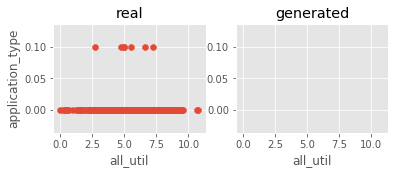

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 408.7296, -381.4219, 101.7190, 1.0000
D Real - D Gen: 483.1409


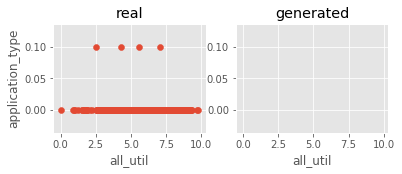

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: 717.7760, -831.3336, -365.2087, 1.0000
D Real - D Gen: 466.1249


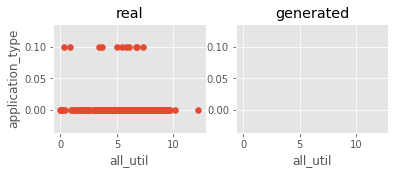

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: 1204.3256, -1175.3175, -671.6173, 0.9966
D Real - D Gen: 503.7002


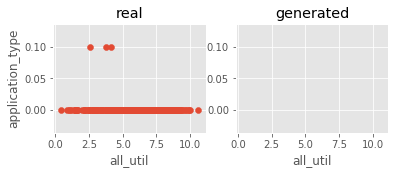

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: 294.3213, -346.6851, 148.7584, 1.0000
D Real - D Gen: 495.4435


Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 389.9892, -303.9497, 214.1460, 1.0000
D Real - D Gen: 518.0957


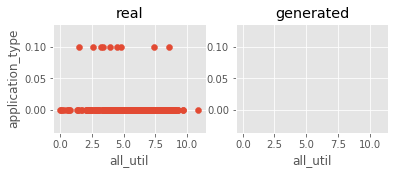

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: -728.3977, 752.4418, 1276.4612, 1.0000
D Real - D Gen: 524.0193


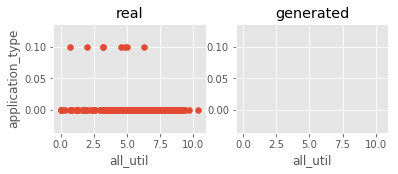

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: -20.7107, 71.7472, 584.1801, 1.0000
D Real - D Gen: 512.4329


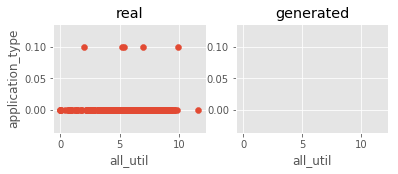

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: 493.2600, -445.3443, 89.5659, 1.0000
D Real - D Gen: 534.9102


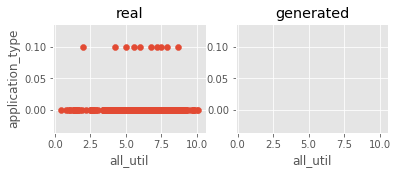

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: 244.4776, -288.1395, 189.8915, 1.0000
D Real - D Gen: 478.0309


Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: -192.0946, 97.5367, 628.1425, 1.0000
D Real - D Gen: 530.6058


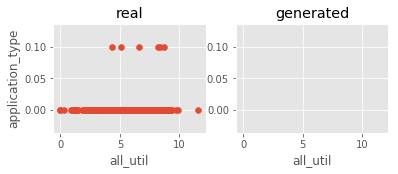

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: -387.7177, 338.0974, 868.6829, 1.0000
D Real - D Gen: 530.5854


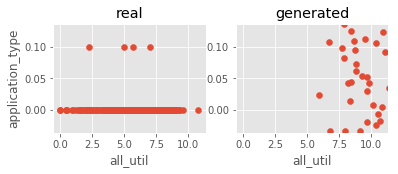

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.9678, 71.2233, 572.5143, 1.0000
D Real - D Gen: 501.2910


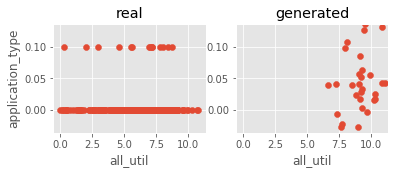

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: 255.4833, -285.3976, 192.8759, 1.0000
D Real - D Gen: 478.2735


Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: -643.1185, 724.8782, 1313.4524, 1.0000
D Real - D Gen: 588.5742


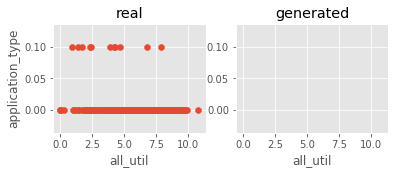

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 68.7756, -183.2499, 325.5462, 1.0000
D Real - D Gen: 508.7961


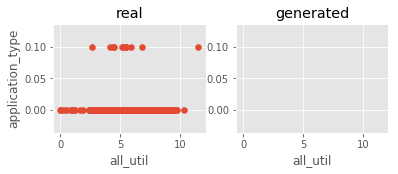

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 109.0981, -80.1898, 442.8866, 1.0000
D Real - D Gen: 523.0764


Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 100.8618, -4.5040, 489.4278, 1.0000
D Real - D Gen: 493.9318


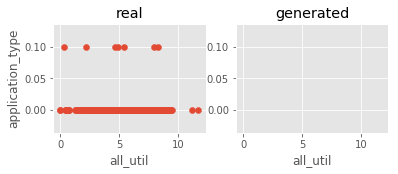

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: -405.3909, 468.9890, 920.9357, 1.0000
D Real - D Gen: 451.9467


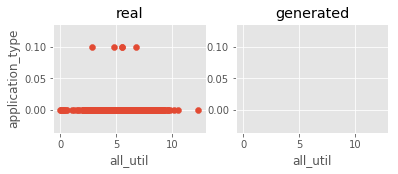

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 564.7991, -597.5562, -22.2003, 1.0000
D Real - D Gen: 575.3559


Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 447.6386, -344.6236, 146.3588, 1.0000
D Real - D Gen: 490.9824


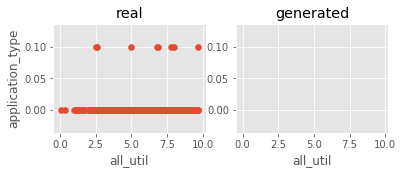

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: 313.8842, -265.7355, 263.4880, 1.0000
D Real - D Gen: 529.2235


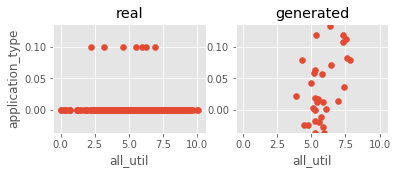

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: 76.4574, -66.7158, 472.3801, 1.0000
D Real - D Gen: 539.0959


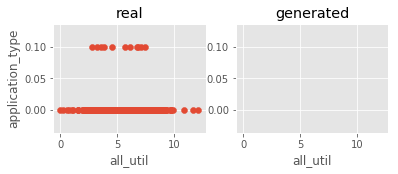

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: -44.0223, 89.9717, 585.1192, 1.0000
D Real - D Gen: 495.1475


Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: 81.7500, -24.1943, 536.8804, 1.0000
D Real - D Gen: 561.0747


Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: -647.8869, 622.7490, 1143.9570, 1.0000
D Real - D Gen: 521.2080


data_dim:  18
data_cols:  ['all_util', 'application_type', 'funded_amnt', 'last_credit_pull_d_month', 'acc_open_past_24mths', 'open_to_total_Acc', 'annual_inc_joint', 'out_prncp', 'sub_grade', 'term', 'delinq_2yrs', 'emp_length', 'home_ownership', 'int_rate', 'total_revol_util', 'interest_ration_to_princi_amt', 'dti_joint', 'total_pymnt']
label_dim:  1
label_cols:  ['Response']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenat

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -53.5347, 51.5990, 22682.6289, 1.0000
D Real - D Gen: 22631.0293


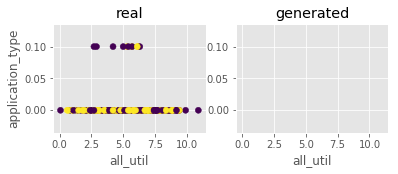

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: -244.4223, 253.6660, 22985.0059, 1.0000
D Real - D Gen: 22731.3398


Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -667.2833, 649.7139, 23274.5605, 1.0000
D Real - D Gen: 22624.8477


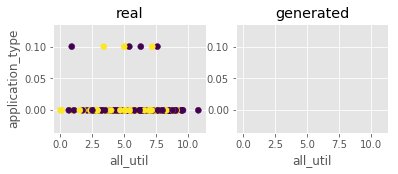

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: -1401.8121, 1394.7390, 20628.7520, 1.0000
D Real - D Gen: 19234.0137


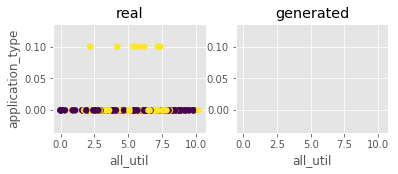

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -2327.2700, 2447.2432, 20009.0430, 1.0000
D Real - D Gen: 17561.8008


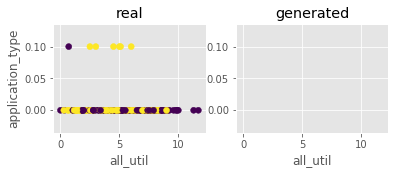

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: -3486.9084, 3442.6733, 18238.5840, 1.0000
D Real - D Gen: 14795.9102


Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: -4082.3669, 4292.4326, 15268.0752, 1.0000
D Real - D Gen: 10975.6426


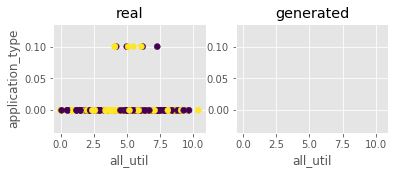

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: -4256.1465, 4552.6255, 11363.2617, 1.0000
D Real - D Gen: 6810.6362


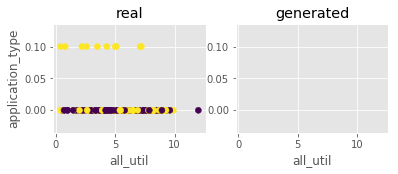

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: -3718.3831, 3718.1445, 7044.2188, 1.0000
D Real - D Gen: 3326.0742


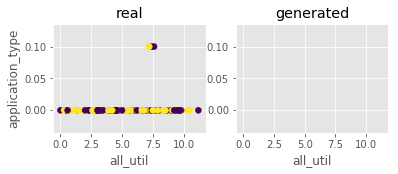

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: -2324.5627, 2303.1147, 3950.6392, 1.0000
D Real - D Gen: 1647.5244


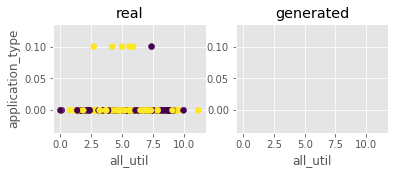

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: -65.2726, -104.8176, 628.6189, 1.0000
D Real - D Gen: 733.4365


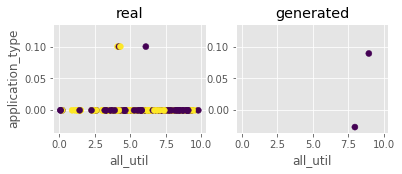

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: -409.5830, 427.2622, 1001.4792, 1.0000
D Real - D Gen: 574.2170


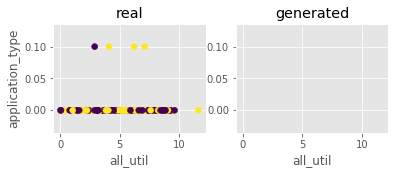

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 69.7489, 17.7563, 607.1552, 1.0000
D Real - D Gen: 589.3989


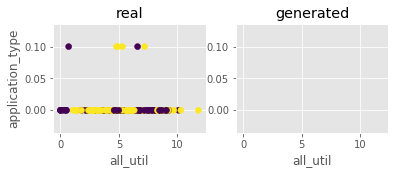

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: -223.1753, 107.2008, 625.6390, 1.0000
D Real - D Gen: 518.4381


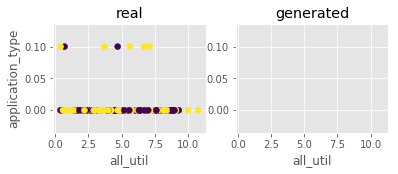

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 7.3526, -35.4601, 457.7569, 1.0000
D Real - D Gen: 493.2170


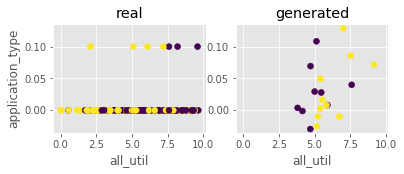

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 89.4521, -34.5484, 473.9728, 1.0000
D Real - D Gen: 508.5212


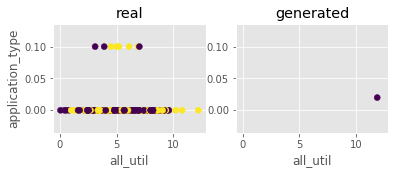

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 296.8272, -509.4970, -23.0805, 1.0000
D Real - D Gen: 486.4166


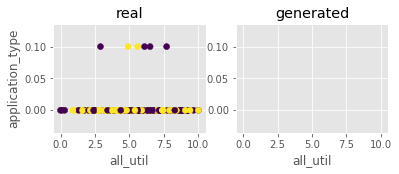

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 561.3243, -845.0824, -331.8388, 1.0000
D Real - D Gen: 513.2436


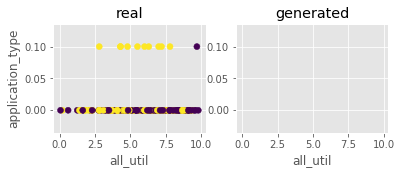

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: -156.9622, 20.3423, 504.5316, 1.0000
D Real - D Gen: 484.1892


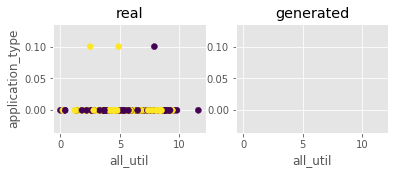

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: -908.9980, 655.8079, 1316.5990, 1.0000
D Real - D Gen: 660.7911


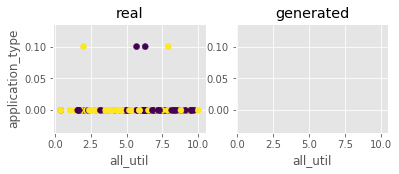

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 530.1689, -398.2293, 131.7354, 1.0000
D Real - D Gen: 529.9647


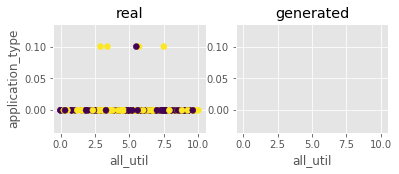

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 127.0298, 104.2132, 553.4227, 1.0000
D Real - D Gen: 449.2095


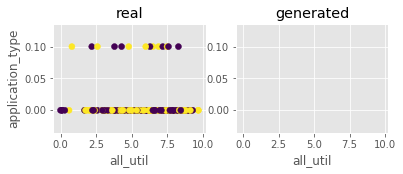

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 277.9478, -269.9477, 231.8963, 1.0000
D Real - D Gen: 501.8440


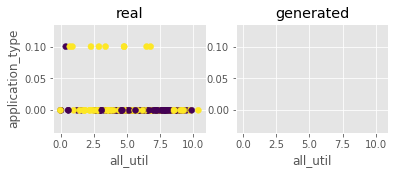

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: -491.2246, 689.2587, 1120.6993, 1.0000
D Real - D Gen: 431.4407


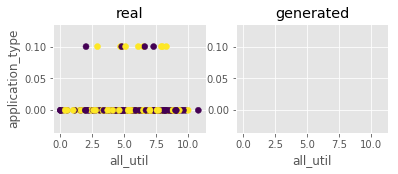

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: -1306.8750, 1274.3700, 1782.3031, 1.0000
D Real - D Gen: 507.9331


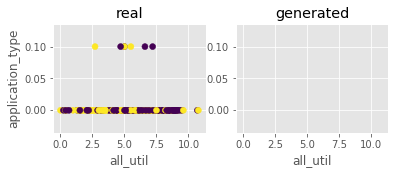

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 275.5587, -217.5479, 271.1985, 1.0000
D Real - D Gen: 488.7464


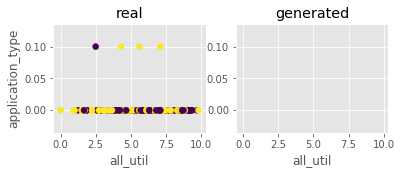

KeyboardInterrupt: 

In [9]:
k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN
